
=== Dataset Info ===
Samples: 1500 | Crops: 15

Crop Distribution:
label
rice           100
maize          100
soya bean      100
beans          100
lentil         100
pomegranate    100
banana         100
mango          100
grapes         100
apple          100
orange         100
coconut        100
cotton         100
jute           100
coffee         100
Name: count, dtype: int64

Training Random Forest...

=== Evaluation Metrics ===
Accuracy: 0.9967
Precision: 0.9968
Recall: 0.9967
F1-Score: 0.9967

=== Classification Report ===
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        20
      banana       1.00      1.00      1.00        20
       beans       1.00      1.00      1.00        20
     coconut       1.00      1.00      1.00        20
      coffee       1.00      1.00      1.00        20
      cotton       1.00      1.00      1.00        20
      grapes       1.00      1.00      1.00        20
        jute       0.95      

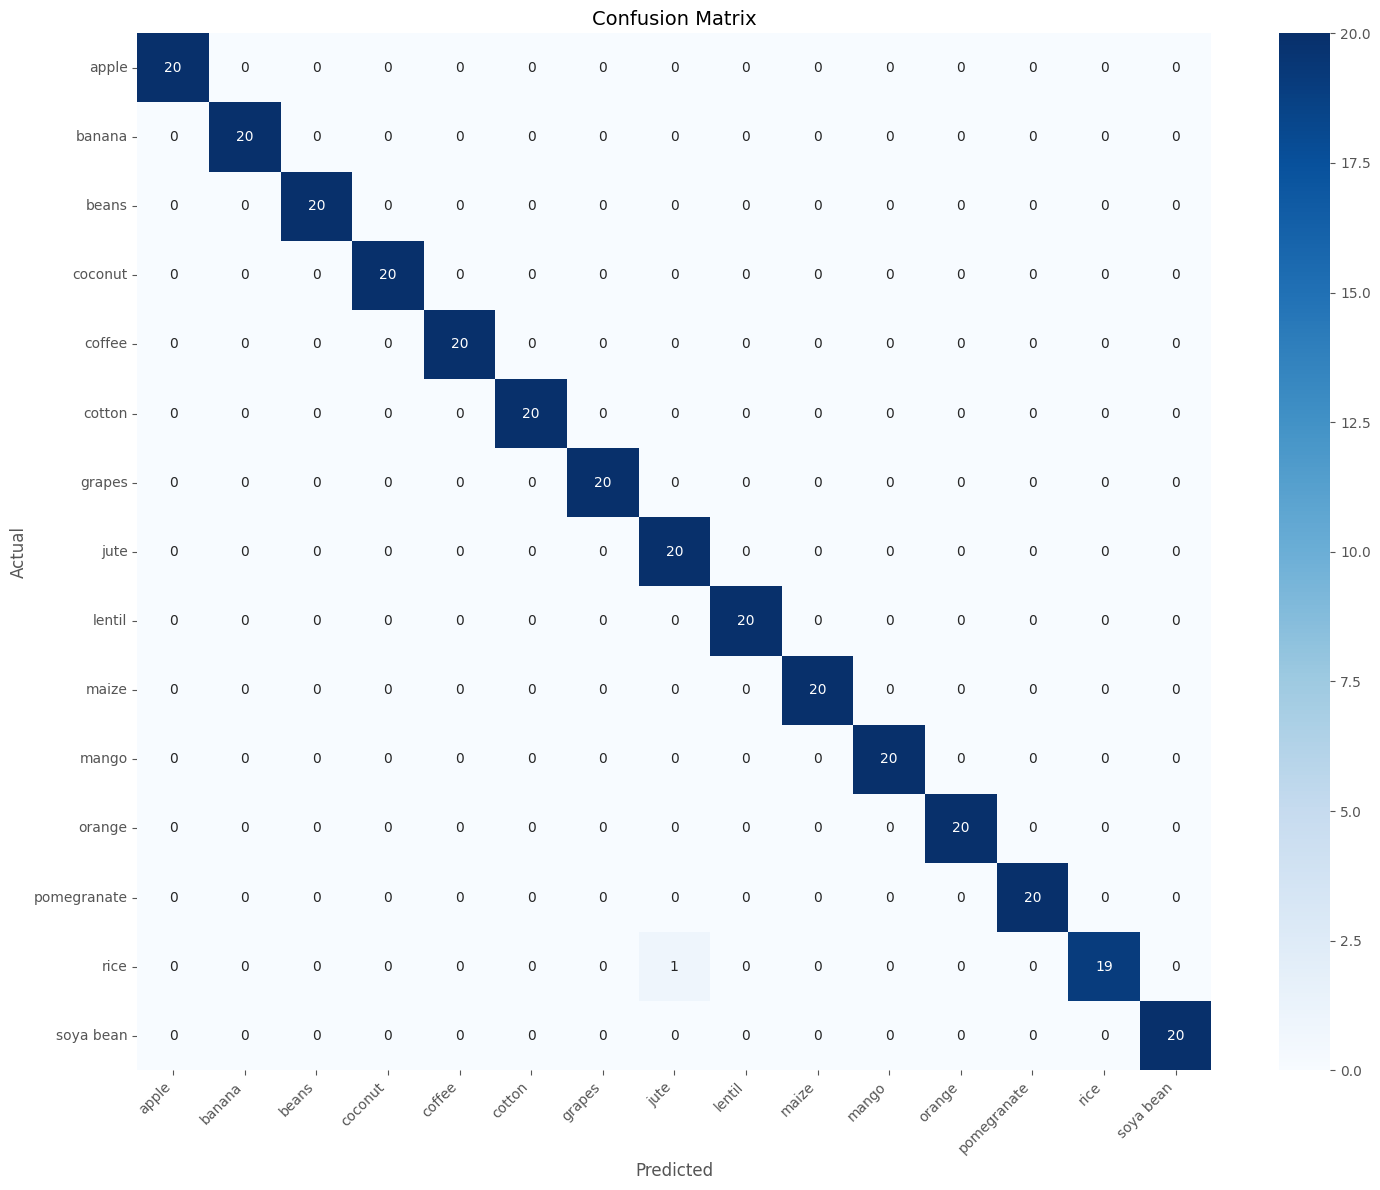


Model saved as crop_recommender_rf.pkl

Enter the following parameters to get a crop recommendation:


Enter Nitrogen (N) level:  96
Enter Phosphorus (P) level:  50
Enter Potassium (K) level:  65
Enter temperature (°C):  40
Enter humidity (%):  50
Enter pH value of the soil:  5.5
Enter rainfall (mm):  200



Prediction for the given parameters:
→ Recommended crop: coffee


In [1]:
# crop_recommendation_rf.py
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, 
                           recall_score, f1_score, classification_report, 
                           confusion_matrix)
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import joblib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Set up visualization
plt.style.use('ggplot')
sns.set_palette('husl')
pd.set_option('display.max_columns', None)

def load_data():
    """Load and preprocess the Kaggle crop dataset"""
    df = pd.read_csv(r'D:\Sem 4 CSE(DS)\DAV\DAV Project\Dataset\.csv\Crop_recommendation_corrected.csv')
    
    # Fix column names
    df = df.rename(columns={'humidity ': 'humidity', 'ph': 'pH'})
    
    # Handle missing values with crop-wise median
    for col in df.columns[:-1]:
        df[col] = df.groupby('label')[col].transform(
            lambda x: x.fillna(x.median()))
    
    # Remove duplicates
    df = df.drop_duplicates()
    
    return df

def analyze_data(df):
    """Generate EDA visuals and stats"""
    print("\n=== Dataset Info ===")
    print(f"Samples: {len(df)} | Crops: {df['label'].nunique()}")
    print("\nCrop Distribution:")
    print(df['label'].value_counts())
    
    # Plot crop distribution
    plt.figure(figsize=(12, 6))
    df['label'].value_counts().plot(kind='bar')
    plt.title("Crop Distribution in Dataset")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('crop_distribution.png', dpi=300)
    plt.close()

def train_random_forest(df):
    """Train and evaluate Random Forest model"""
    # Encode labels
    le = LabelEncoder()
    df['label_encoded'] = le.fit_transform(df['label'])
    
    # Save label mapping
    with open('label_mapping.json', 'w') as f:
        #json.dump(dict(zip(le.classes_, le.transform(le.classes_))), f)
        json.dump({str(k): int(v) for k, v in zip(le.classes_, le.transform(le.classes_))}, f)

    
    # Prepare data
    X = df.drop(['label', 'label_encoded'], axis=1)
    y = df['label_encoded']
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Handle class imbalance with SMOTE
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)
    
    # Initialize Random Forest
    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=5,
        class_weight='balanced_subsample',
        random_state=42,
        n_jobs=-1
    )
    
    # Train
    print("\nTraining Random Forest...")
    rf.fit(X_train, y_train)
    
    # Evaluate
    y_pred = rf.predict(X_test)
    
    print("\n=== Evaluation Metrics ===")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred, average='weighted'):.4f}")
    print(f"F1-Score: {f1_score(y_test, y_pred, average='weighted'):.4f}")
    
    # Classification report
    print("\n=== Classification Report ===")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    
    # Confusion matrix
    plt.figure(figsize=(15, 12))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', 
                xticklabels=le.classes_, 
                yticklabels=le.classes_,
                cmap='Blues')
    plt.title("Confusion Matrix", fontsize=14)
    plt.xlabel("Predicted", fontsize=12)
    plt.ylabel("Actual", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    plt.savefig('confusion_matrix.png', dpi=300)
    plt.close()
     
    return rf, le

def save_model(model, encoder, filename='crop_recommender_rf.pkl'):
    """Save model pipeline"""
    pipeline = {
        'model': model,
        'encoder': encoder,
        'features': ['N', 'P', 'K', 'temperature', 'humidity', 'pH', 'rainfall']
    }
    joblib.dump(pipeline, filename)
    print(f"\nModel saved as {filename}")

def example_prediction(model, encoder):
    """Takes user input for crop parameters and predicts the recommended crop."""
    print("\nEnter the following parameters to get a crop recommendation:")
    
    # Take user input for each parameter
    N = float(input("Enter Nitrogen (N) level: "))
    P = float(input("Enter Phosphorus (P) level: "))
    K = float(input("Enter Potassium (K) level: "))
    temperature = float(input("Enter temperature (°C): "))
    humidity = float(input("Enter humidity (%): "))
    pH = float(input("Enter pH value of the soil: "))
    rainfall = float(input("Enter rainfall (mm): "))
    
    # Store input in a dictionary
    sample_data = {
        'N': N,
        'P': P,
        'K': K,
        'temperature': temperature,
        'humidity': humidity,
        'pH': pH,
        'rainfall': rainfall
    }
    
    # Convert to DataFrame for prediction
    sample_df = pd.DataFrame([sample_data])
    
    # Make prediction
    pred_num = model.predict(sample_df)[0]
    pred_crop = encoder.inverse_transform([pred_num])[0]
    
    # Display the result
    print(f"\nPrediction for the given parameters:")
    print(f"→ Recommended crop: {pred_crop}")

if __name__ == "__main__":
    # Load and analyze data
    df = load_data()
    analyze_data(df)
    
    # Train model
    model, encoder = train_random_forest(df)
    
    # Save model
    save_model(model, encoder)
    
    # Demo prediction
    example_prediction(model, encoder)

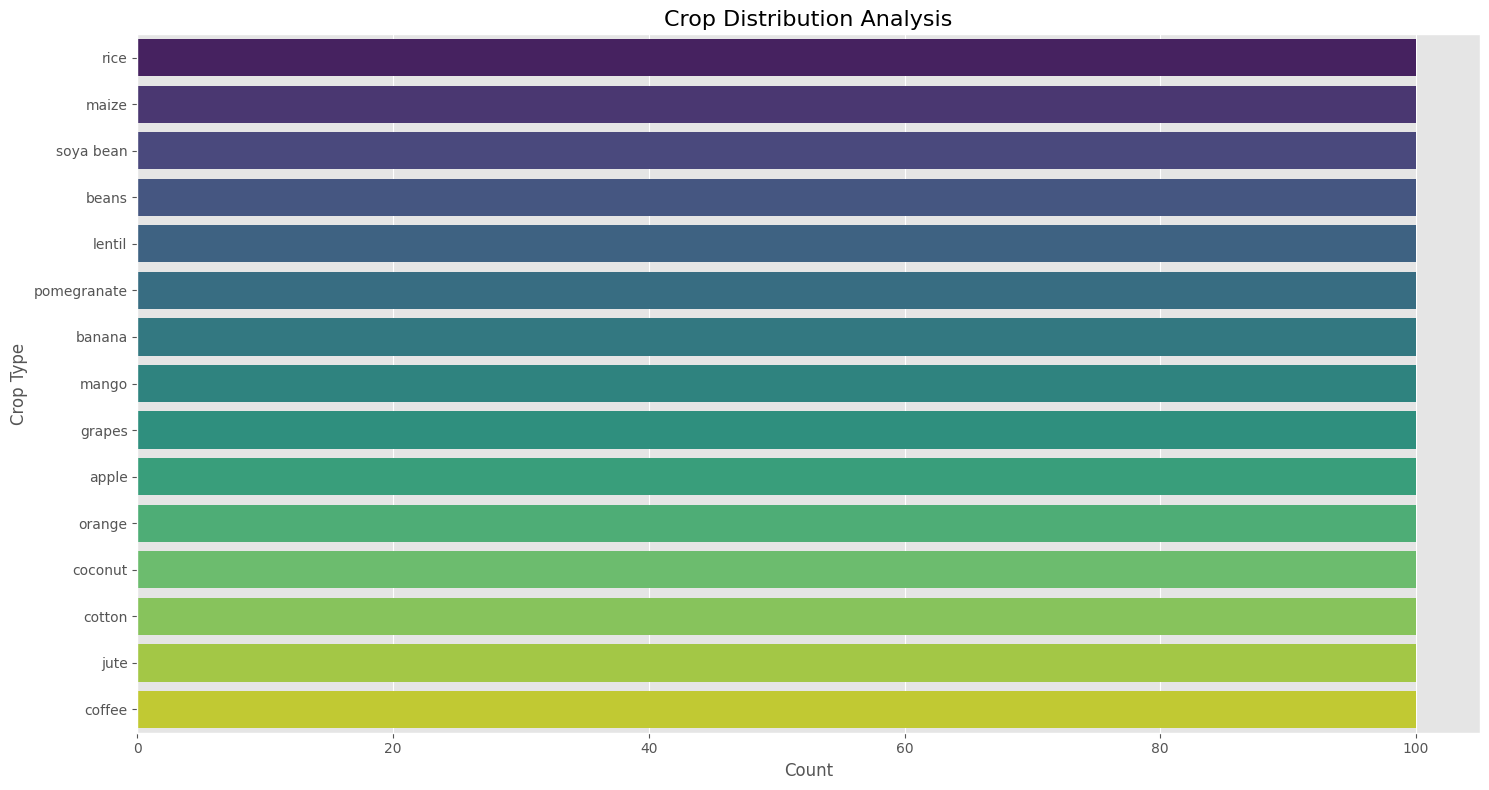

This histogram shows that equal number of samples(100) for all 15 crops is taken


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from mpl_toolkits.mplot3d import Axes3D

# ========================
# DATA PREPARATION
# ========================

# Load dataset
df = pd.read_csv(r'D:\Sem 4 CSE(DS)\DAV\DAV Project\Dataset\.csv\Crop_recommendation_corrected.csv')

# Data validation
numeric_cols = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# 1. Crop Distribution Analysis (Fixed)
plt.figure(figsize=(15,8))
sns.countplot(y='label', data=df, 
             order=df['label'].value_counts().index,
             hue='label', 
             palette='viridis',
             legend=False)
plt.title("Crop Distribution Analysis", fontsize=16)
plt.xlabel("Count", fontsize=12)
plt.ylabel("Crop Type", fontsize=12)
plt.tight_layout()
plt.savefig('crop_distribution.png', dpi=300)
plt.show()
plt.close()
print("This histogram shows that equal number of samples(100) for all 15 crops is taken")


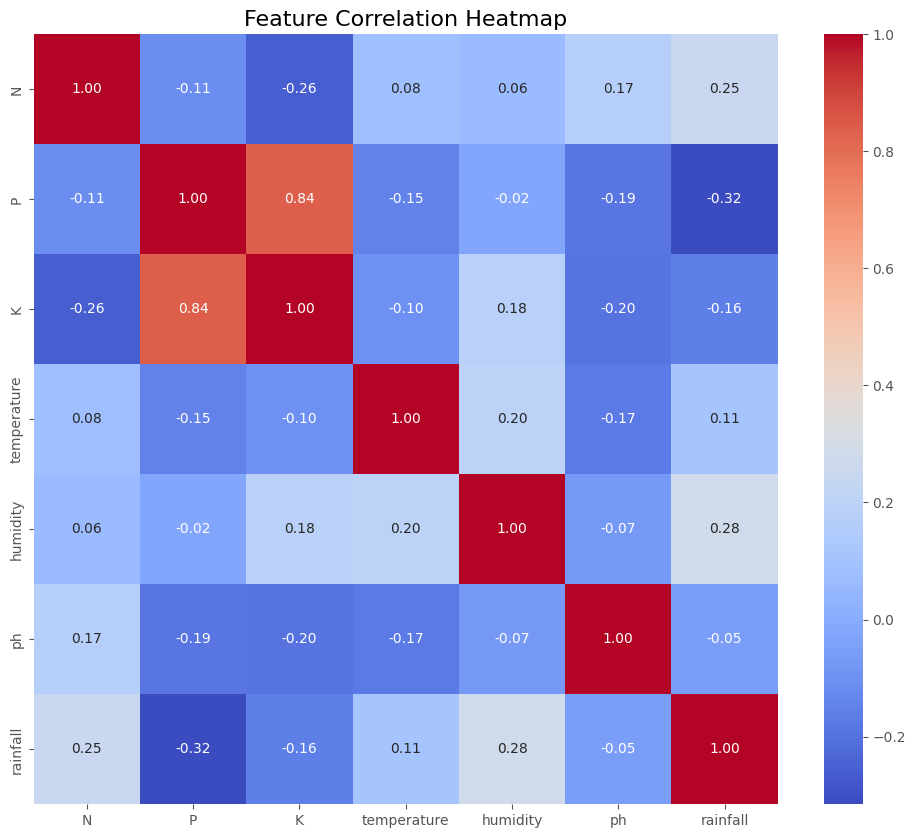


🔍 Top Positive Correlations (> 0.5):
P  K    0.837669
dtype: float64

🔍 Top Negative Correlations (< -0.2):
N  K          -0.262151
P  rainfall   -0.315691
dtype: float64

✅ Key Observations:
- P and K are strongly positively correlated.
- N is weakly or negatively correlated with P and K.
- Rainfall correlates positively with N and humidity, but negatively with P.
- pH is nearly uncorrelated with most variables.


In [4]:
# 2. Nutrient Correlation Analysis (Fixed)
plt.figure(figsize=(12,10))
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap", fontsize=16)
plt.savefig('correlation_matrix.png', dpi=300)
plt.show()
plt.close()

# Extract top insights programmatically
print("\n🔍 Top Positive Correlations (> 0.5):")
high_corr = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
high_corr_pairs = high_corr.stack().sort_values(ascending=False)
print(high_corr_pairs[high_corr_pairs > 0.5])

print("\n🔍 Top Negative Correlations (< -0.2):")
print(high_corr_pairs[high_corr_pairs < -0.2])

print("\n✅ Key Observations:")
print("- P and K are strongly positively correlated.")
print("- N is weakly or negatively correlated with P and K.")
print("- Rainfall correlates positively with N and humidity, but negatively with P.")
print("- pH is nearly uncorrelated with most variables.")


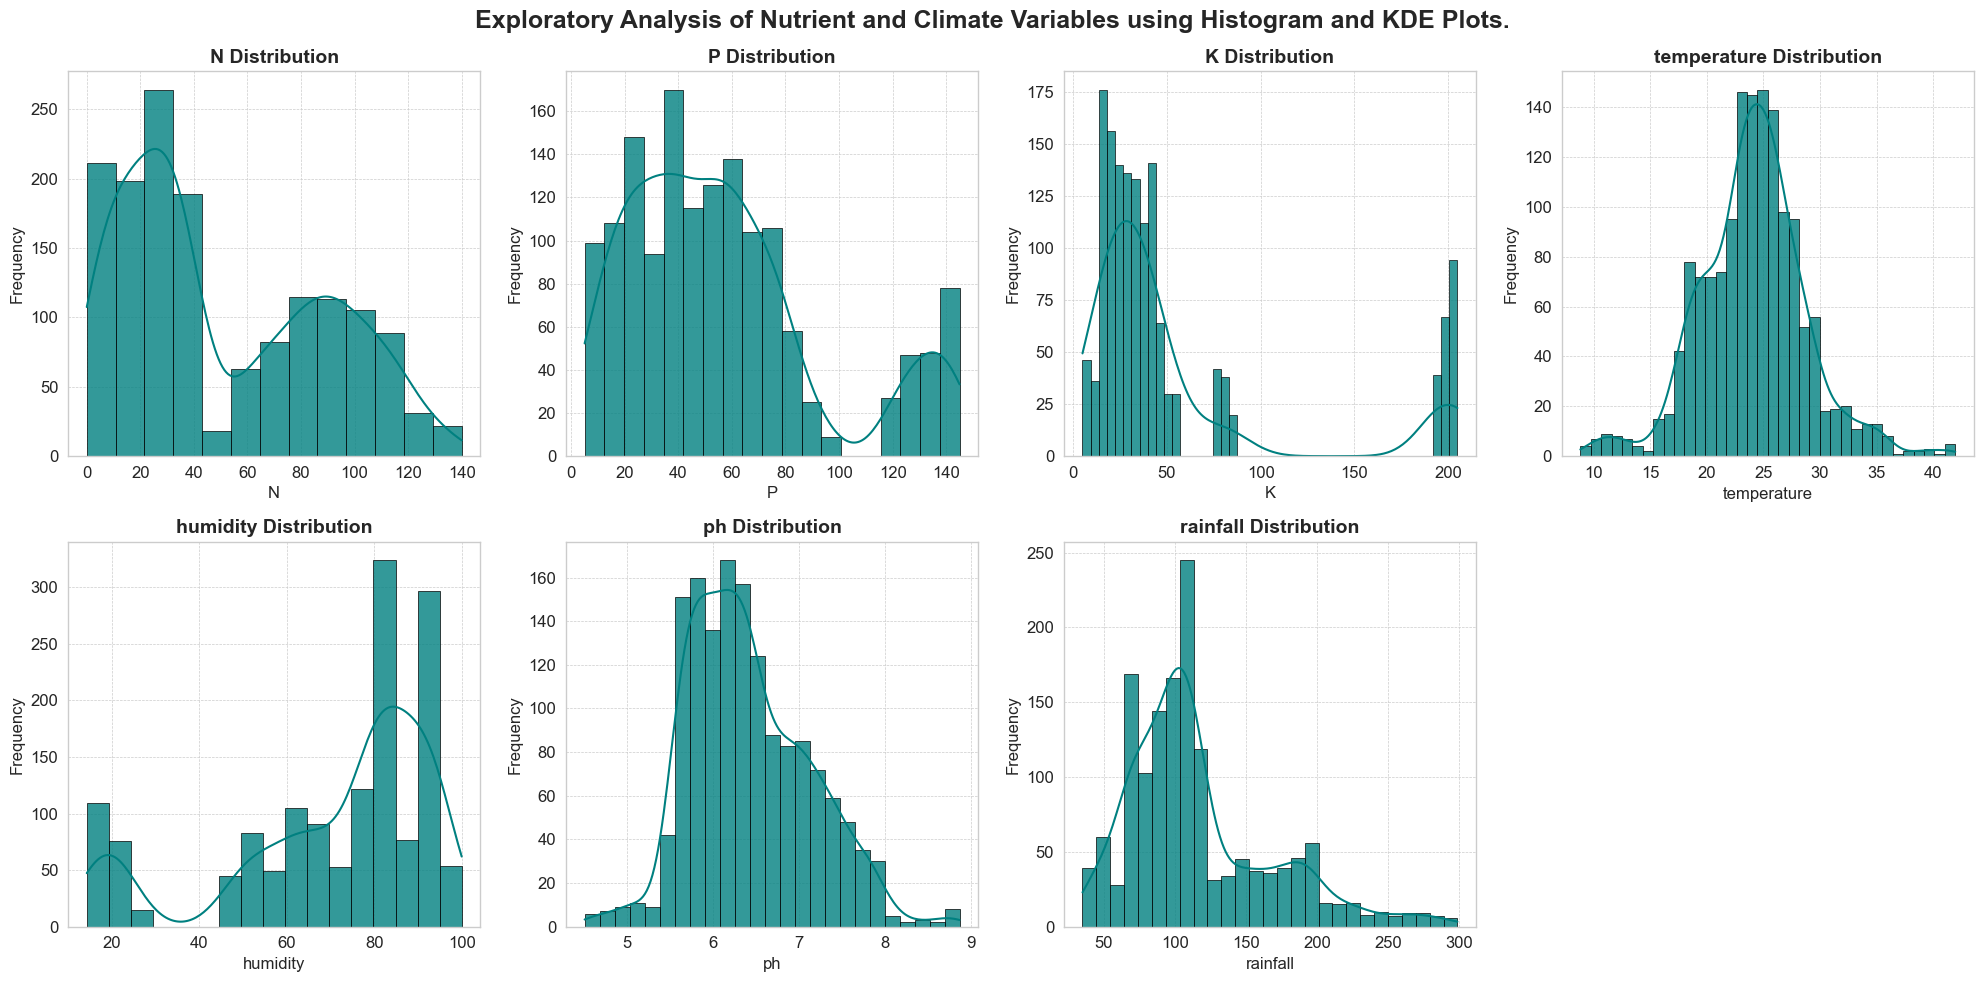


--- N ---
Mean: 50.62
Median: 37.00
Standard Deviation: 37.76
Range: 0.00 to 140.00
Skewness: 0.49 (symmetrical)

--- P ---
Mean: 56.65
Median: 51.00
Standard Deviation: 36.79
Range: 5.00 to 145.00
Skewness: 0.93 (right-skewed)

--- K ---
Mean: 55.29
Median: 34.00
Standard Deviation: 59.11
Range: 5.00 to 205.00
Skewness: 1.86 (right-skewed)
→ Highly skewed distribution; may need transformation.

--- temperature ---
Mean: 24.08
Median: 24.14
Standard Deviation: 4.69
Range: 8.83 to 41.95
Skewness: 0.10 (symmetrical)
→ Possible outliers present at the upper end.

--- humidity ---
Mean: 70.06
Median: 80.00
Standard Deviation: 23.80
Range: 14.26 to 99.98
Skewness: -1.10 (left-skewed)
→ Highly skewed distribution; may need transformation.

--- ph ---
Mean: 6.42
Median: 6.31
Standard Deviation: 0.71
Range: 4.51 to 8.87
Skewness: 0.52 (right-skewed)
→ Possible outliers present at the upper end.

--- rainfall ---
Mean: 116.08
Median: 105.06
Standard Deviation: 50.94
Range: 35.03 to 298.56
Skew

In [5]:
# Nutrient Histograms
sns.set_style("whitegrid")
sns.set_palette("Set2")
plt.rcParams.update({'font.size': 12})

# Define the features to plot
features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']

# Create subplots (2 rows, 4 columns to spread out the plots better)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

# Plot histograms with KDE
for i, feature in enumerate(features):
    sns.histplot(df[feature], ax=axes[i], kde=True, color='teal', edgecolor='black', alpha=0.8)
    axes[i].set_title(f"{feature} Distribution", fontsize=14, weight='bold')
    axes[i].set_xlabel(feature, fontsize=12)
    axes[i].set_ylabel("Frequency", fontsize=12)
    axes[i].grid(True, linestyle='--', linewidth=0.5)

# Hide any unused subplot (in case of odd number of features)
for j in range(len(features), len(axes)):
    fig.delaxes(axes[j])

# Save and display the plot
fig.suptitle("Exploratory Analysis of Nutrient and Climate Variables using Histogram and KDE Plots.", fontsize=18, weight='bold')
plt.tight_layout()
plt.savefig('better_nutrient_histograms.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

#Analysis
import pandas as pd
from scipy.stats import skew, kurtosis

# Define features to analyze
features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']

# Generate statistical insights
for feature in features:
    print(f"\n--- {feature} ---")
    mean_val = df[feature].mean()
    median_val = df[feature].median()
    std_val = df[feature].std()
    min_val = df[feature].min()
    max_val = df[feature].max()
    skew_val = skew(df[feature])

    # Basic interpretation
    shape = "symmetrical" if abs(skew_val) < 0.5 else "right-skewed" if skew_val > 0 else "left-skewed"
    
    print(f"Mean: {mean_val:.2f}")
    print(f"Median: {median_val:.2f}")
    print(f"Standard Deviation: {std_val:.2f}")
    print(f"Range: {min_val:.2f} to {max_val:.2f}")
    print(f"Skewness: {skew_val:.2f} ({shape})")
    

    # Extra insights
    if skew_val > 1 or skew_val < -1:
        print("→ Highly skewed distribution; may need transformation.")
    if max_val > mean_val + 3 * std_val:
        print("→ Possible outliers present at the upper end.")


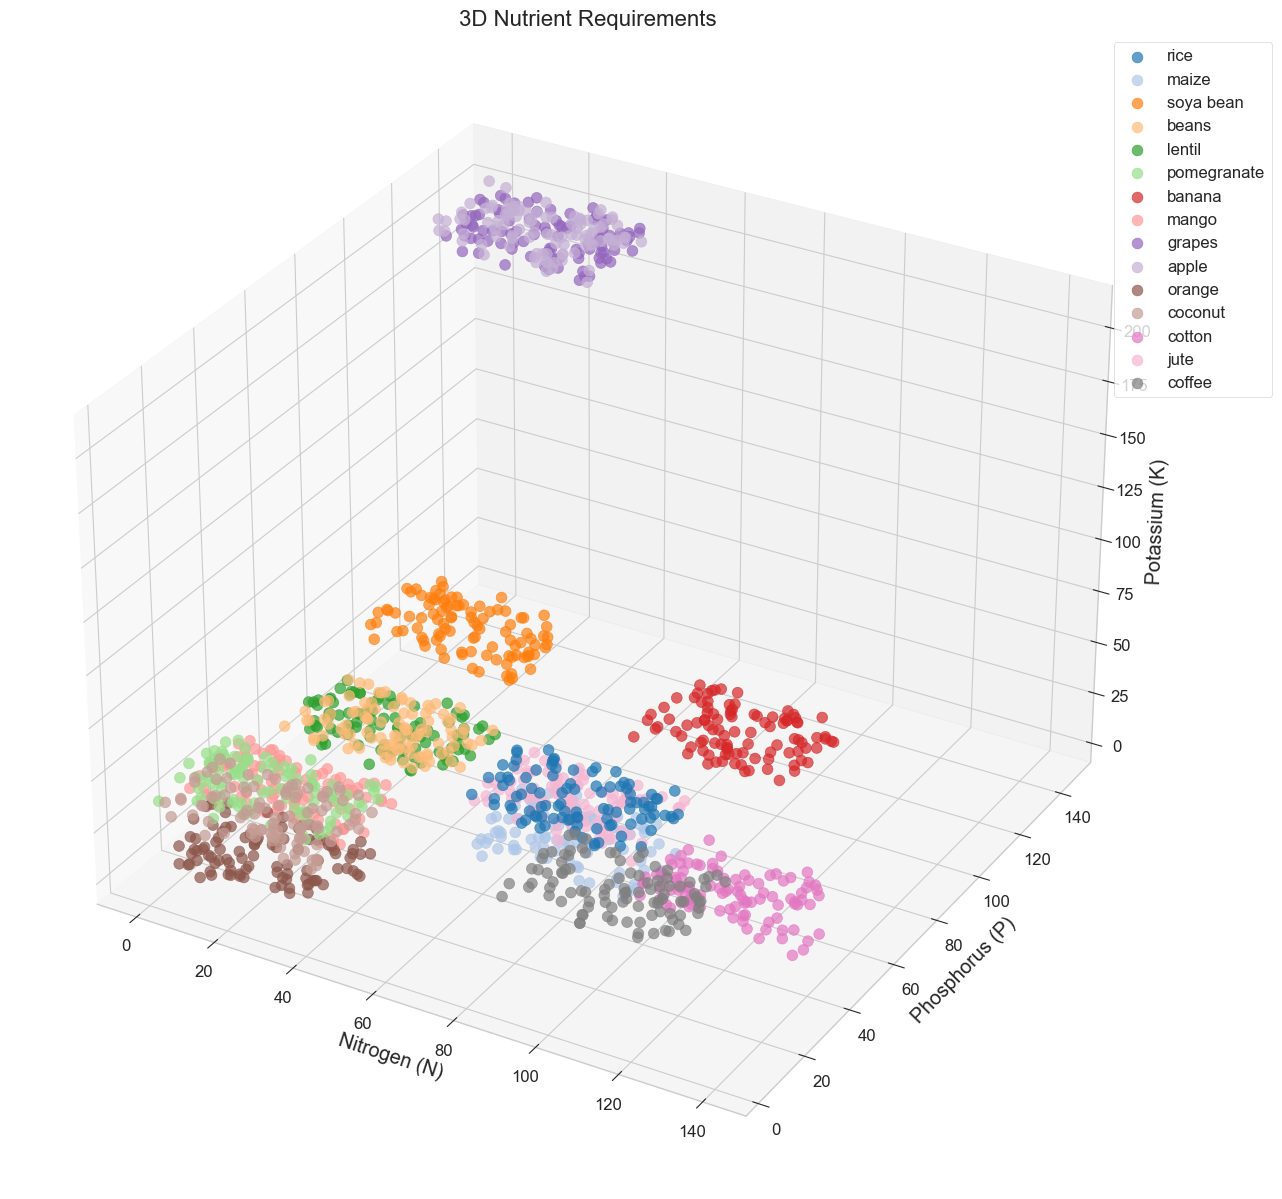


🌾 Top 5 Crops by Nitrogen Requirement:
        N_mean
label         
cotton  117.77
coffee  101.20
banana  100.23
rice     79.89
jute     78.40

🌿 Bottom 5 Crops by Nitrogen Requirement:
             N_mean
label              
beans         20.75
mango         20.07
orange        19.58
pomegranate   18.87
lentil        18.77

🌻 Top 5 Crops by Phosphorus Requirement:
           P_mean
label            
apple      134.22
grapes     132.53
banana      82.01
lentil      68.36
soya bean   67.79

🍀 Bottom 5 Crops by Phosphorus Requirement:
             P_mean
label              
coffee        28.74
mango         27.18
pomegranate   18.75
coconut       16.93
orange        16.55

🍇 Top 5 Crops by Potassium Requirement:
             K_mean
label              
grapes       200.11
apple        199.89
soya bean     79.92
banana        50.05
pomegranate   40.21

🥬 Bottom 5 Crops by Potassium Requirement:
        K_mean
label         
beans    20.05
maize    19.79
cotton   19.56
lentil   19.41
oran

In [8]:
# 3. 3D Nutrient Space Analysis
top_crops = df['label'].value_counts().index[:]
fig = plt.figure(figsize=(18, 15))
ax = fig.add_subplot(111, projection='3d')

colors = plt.cm.tab20.colors
for idx, crop in enumerate(top_crops):
    crop_df = df[df['label'] == crop]
    ax.scatter(crop_df['N'], crop_df['P'], crop_df['K'], 
               label=crop, s=60, alpha=0.7, color=colors[idx])

ax.set_xlabel('Nitrogen (N)')
ax.set_ylabel('Phosphorus (P)')
ax.set_zlabel('Potassium (K)')
ax.legend(bbox_to_anchor=(1.1, 1))
plt.title('3D Nutrient Requirements', fontsize=16)
plt.savefig('3d_nutrients.png', dpi=300)
plt.show()
plt.close()

# Printed Analysis
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Define nutrient columns
nutrient_cols = ['N', 'P', 'K']

# Group by crop label and compute stats
grouped_stats = df.groupby('label')[nutrient_cols].agg(['mean', 'std', 'min', 'max'])
grouped_stats.columns = ['_'.join(col) for col in grouped_stats.columns]
grouped_stats = grouped_stats.sort_values(by='N_mean', ascending=False)

# ---- 🔍 Insights for Nitrogen ----
print("\n🌾 Top 5 Crops by Nitrogen Requirement:")
print(grouped_stats[['N_mean']].head())

print("\n🌿 Bottom 5 Crops by Nitrogen Requirement:")
print(grouped_stats[['N_mean']].tail())

# ---- 🔍 Insights for Phosphorus ----
grouped_stats = grouped_stats.sort_values(by='P_mean', ascending=False)
print("\n🌻 Top 5 Crops by Phosphorus Requirement:")
print(grouped_stats[['P_mean']].head())

print("\n🍀 Bottom 5 Crops by Phosphorus Requirement:")
print(grouped_stats[['P_mean']].tail())

# ---- 🔍 Insights for Potassium ----
grouped_stats = grouped_stats.sort_values(by='K_mean', ascending=False)
print("\n🍇 Top 5 Crops by Potassium Requirement:")
print(grouped_stats[['K_mean']].head())

print("\n🥬 Bottom 5 Crops by Potassium Requirement:")
print(grouped_stats[['K_mean']].tail())

# ---- 📊 Summary per Crop ----
print("\n📊 Nutrient Spread Summary (mean ± std):")
for crop in df['label'].unique():
    row = grouped_stats.loc[crop]
    print(f"\n🔸 {crop}")
    print(f"  - Nitrogen: {row['N_mean']:.2f} ± {row['N_std']:.2f}")
    print(f"  - Phosphorus: {row['P_mean']:.2f} ± {row['P_std']:.2f}")
    print(f"  - Potassium: {row['K_mean']:.2f} ± {row['K_std']:.2f}")

# ---- 🧪 KMeans Clustering for Similar Nutrient Needs ----
X = df[nutrient_cols]
X_scaled = StandardScaler().fit_transform(X)

kmeans = KMeans(n_clusters=5, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

print("\n🧪 Cluster Summary (Crops grouped by similar NPK):")
print(df.groupby(['cluster', 'label']).size())


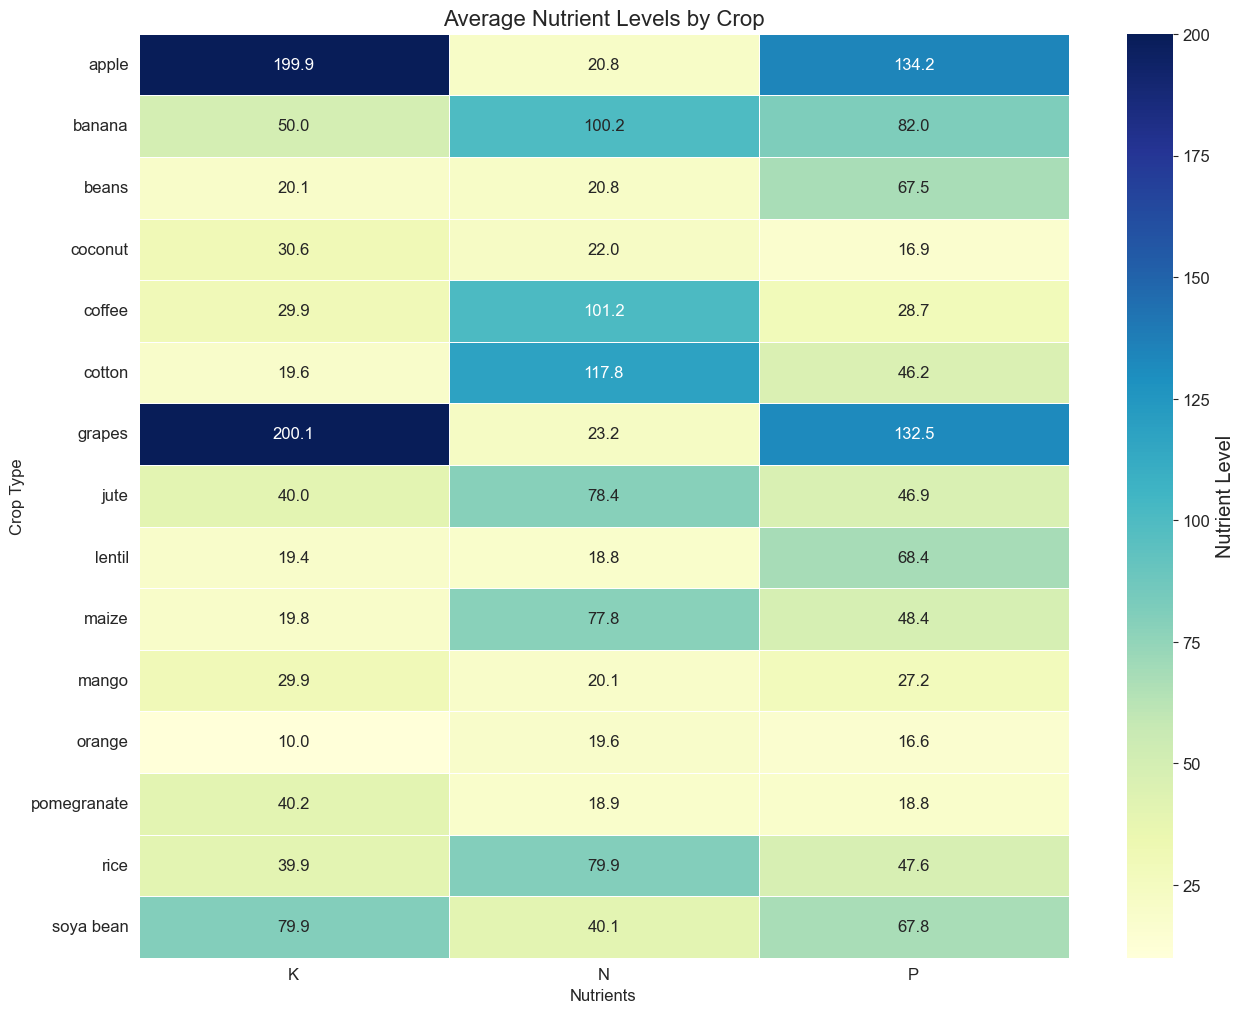

In [9]:
# Nutrient Heatmap by Crop
pivot_table = df.pivot_table(values=['N', 'P', 'K'], 
                            index='label', 
                            aggfunc='mean')
plt.figure(figsize=(15,12))
sns.heatmap(pivot_table, 
           annot=True, 
           cmap='YlGnBu',
           fmt=".1f",
           linewidths=.5,
           cbar_kws={'label': 'Nutrient Level'})
plt.title('Average Nutrient Levels by Crop', fontsize=16)
plt.ylabel('Crop Type', fontsize=12)
plt.xlabel('Nutrients', fontsize=12)
plt.savefig('6_nutrient_heatmap.png', dpi=300)
plt.show()
plt.close()

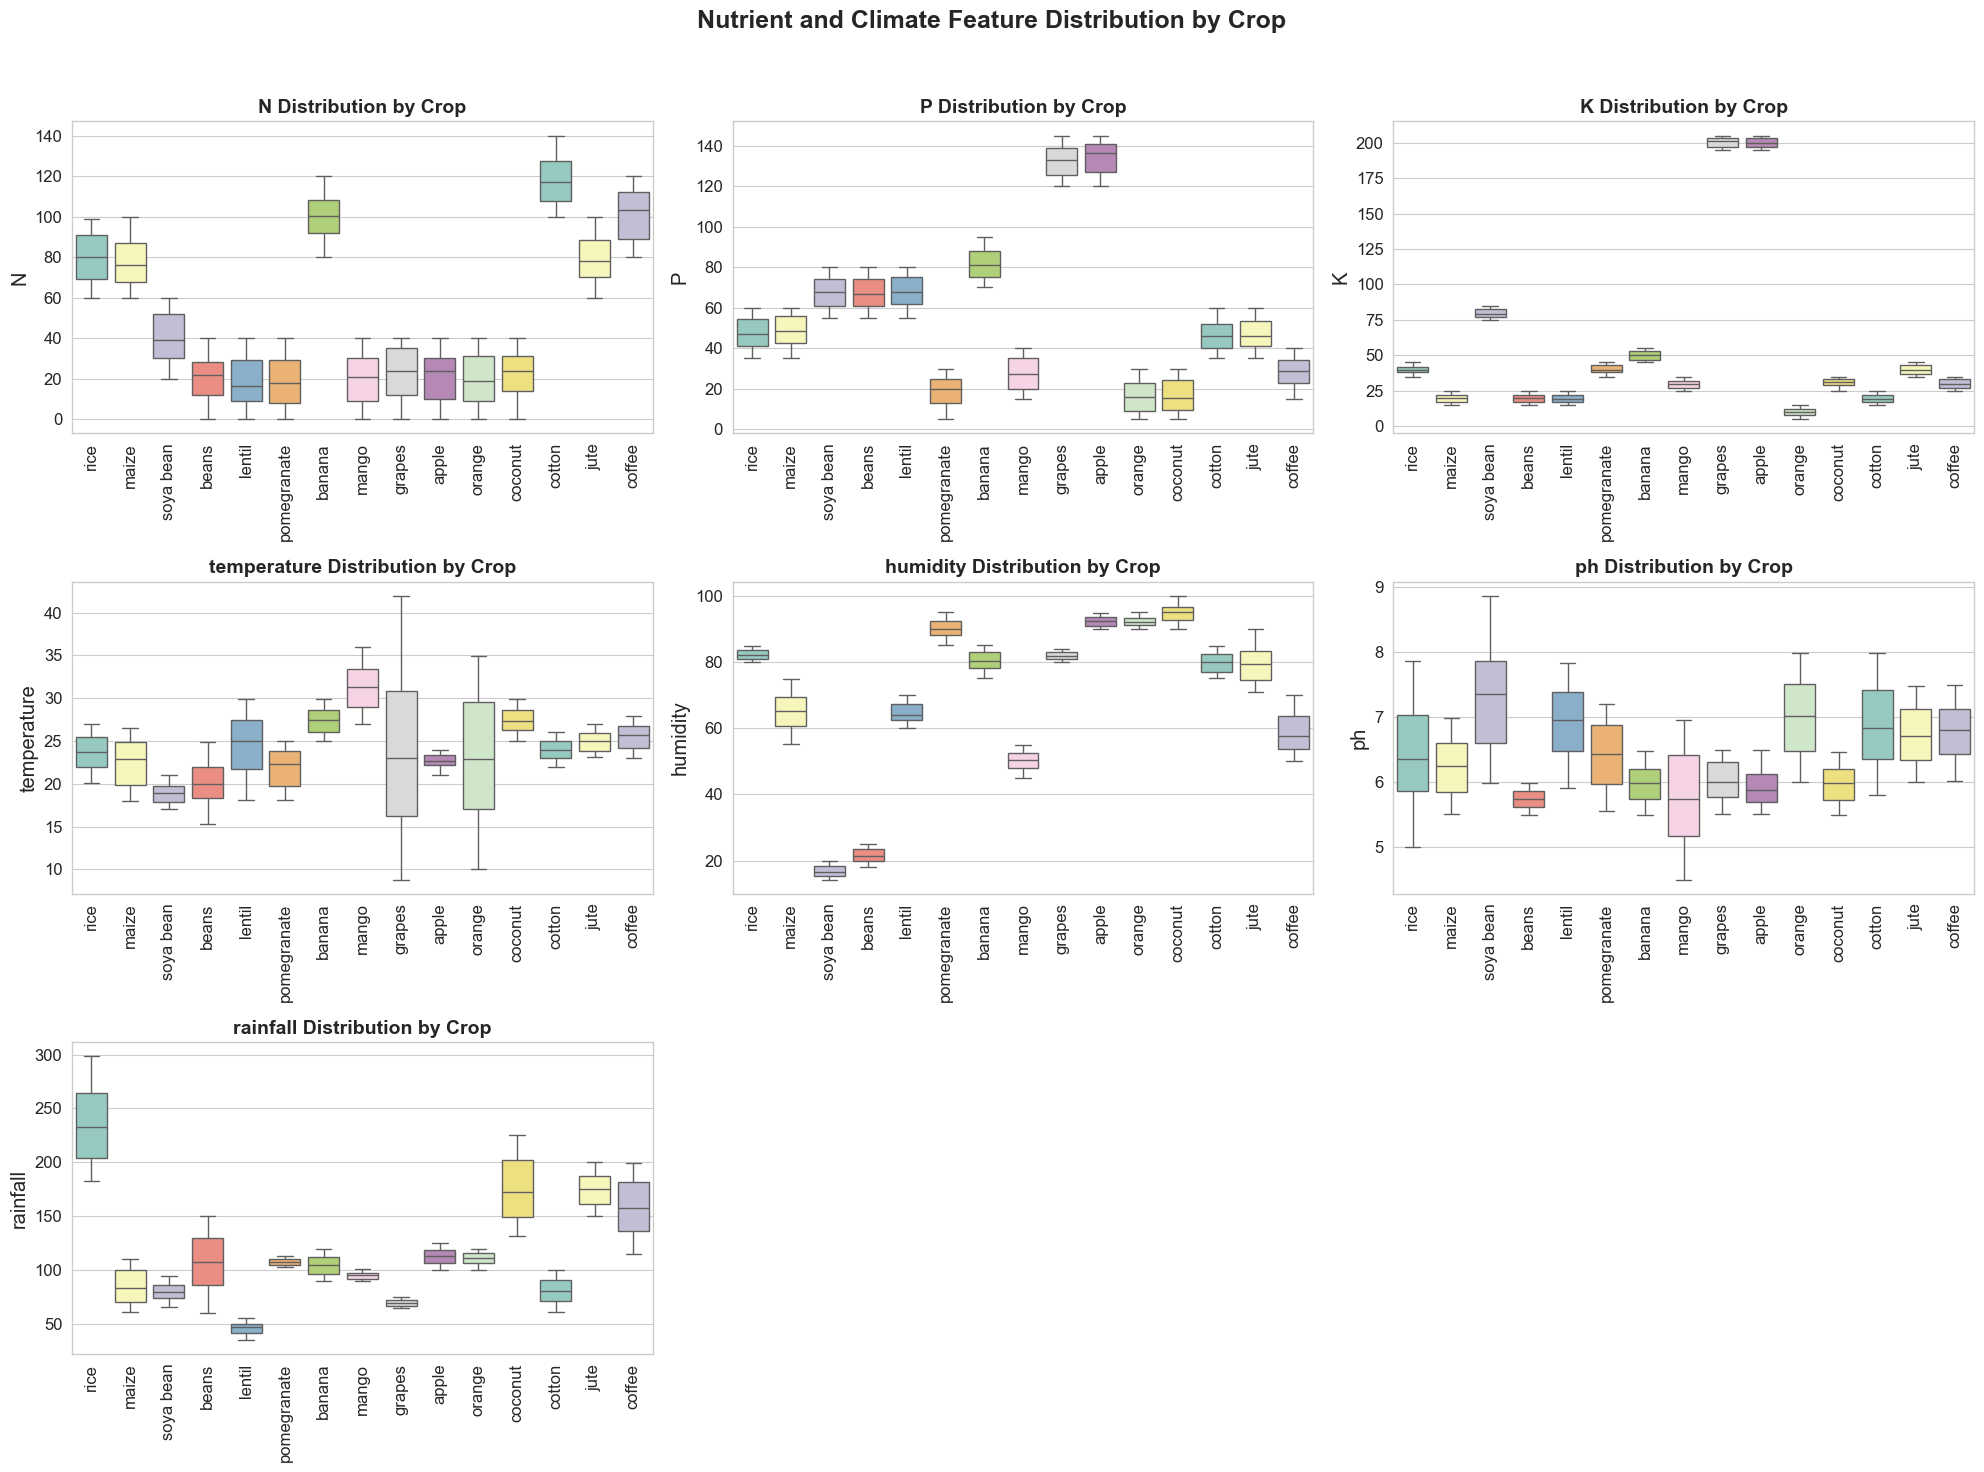


🔍 Automated Insights by Feature:


📌 Feature: N

Top Crops by Median Value:
label
cotton    117.0
coffee    103.0
banana    100.5

Crops with Most Outliers:
  rice: 0 outliers
  maize: 0 outliers
  soya bean: 0 outliers

📌 Feature: P

Top Crops by Median Value:
label
apple     136.5
grapes    133.0
banana     81.0

Crops with Most Outliers:
  rice: 0 outliers
  maize: 0 outliers
  soya bean: 0 outliers

📌 Feature: K

Top Crops by Median Value:
label
grapes       201.0
apple        200.0
soya bean     79.0

Crops with Most Outliers:
  rice: 0 outliers
  maize: 0 outliers
  soya bean: 0 outliers

📌 Feature: temperature

Top Crops by Median Value:
label
mango      31.300223
banana     27.443333
coconut    27.385317

Crops with Most Outliers:
  rice: 0 outliers
  maize: 0 outliers
  soya bean: 0 outliers

📌 Feature: humidity

Top Crops by Median Value:
label
coconut    94.960581
apple      92.416541
orange     91.963246

Crops with Most Outliers:
  rice: 0 outliers
  maize: 0 outliers
  s

In [12]:
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12})

# Define features and crops
features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
crops    = df['label'].unique()

# Create a 3×3 grid of boxplots
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i]
    # Use hue='label' + dodge=False so palette is applied, but boxes don't split
    sns.boxplot(
        x='label', 
        y=feature, 
        data=df, 
        hue='label', 
        palette='Set3', 
        dodge=False,
        ax=ax
    )
    # remove the extra legend
    if ax.get_legend():
        ax.get_legend().remove()

    ax.set_title(f'{feature} Distribution by Crop', fontsize=14, weight='bold')
    ax.set_xlabel('')
    ax.set_ylabel(feature)
    ax.tick_params(axis='x', rotation=90)

# Remove the two unused subplots
for j in range(len(features), len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Nutrient and Climate Feature Distribution by Crop", fontsize=18, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('cropwise_boxplots.png', dpi=300)
plt.show()
plt.close()

# Part 2: Insights
print("\n🔍 Automated Insights by Feature:\n")

for feature in features:
    print(f"\n📌 Feature: {feature}")
    
    # Median values per crop
    medians = df.groupby('label')[feature].median().sort_values(ascending=False)
    print("\nTop Crops by Median Value:")
    print(medians.head(3).to_string())

    # Count outliers per crop (values outside 1.5*IQR)
    outlier_info = {}
    for crop in crops:
        crop_data = df[df['label'] == crop][feature]
        Q1 = crop_data.quantile(0.25)
        Q3 = crop_data.quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outliers = crop_data[(crop_data < lower) | (crop_data > upper)]
        outlier_info[crop] = len(outliers)
    
    sorted_outliers = sorted(outlier_info.items(), key=lambda x: x[1], reverse=True)
    print("\nCrops with Most Outliers:")
    for crop, count in sorted_outliers[:3]:
        print(f"  {crop}: {count} outliers")

In [6]:
import pandas as pd
from scipy.stats import f_oneway

# Load the dataset
df = pd.read_csv(r'D:\Sem 4 CSE(DS)\DAV\DAV Project\Dataset\.csv\Crop_recommendation_corrected.csv')

# List of numerical features to test
features = ['rainfall', 'ph', 'temperature', 'humidity', 'N', 'P', 'K']
group_col = 'label'

# Group by crop
grouped = df.groupby(group_col)

# Run ANOVA for each feature
print("🔬 One-Way ANOVA Results Across Crops:")
print("--------------------------------------")

for feature in features:
    # Prepare lists of feature values for each crop
    groups = [group[feature].dropna().values for name, group in grouped]
    
    # Perform ANOVA
    f_stat, p_val = f_oneway(*groups)
    
    print(f"{feature}: F = {f_stat:.3f}, p = {p_val:.3f}")
    
    if p_val < 0.05:
        print("✅ Significant differences detected among crops.")
    else:
        print("⚪ No significant differences across crops.")
    print()


🔬 One-Way ANOVA Results Across Crops:
--------------------------------------
rainfall: F = 868.431, p = 0.000
✅ Significant differences detected among crops.

ph: F = 100.080, p = 0.000
✅ Significant differences detected among crops.

temperature: F = 69.727, p = 0.000
✅ Significant differences detected among crops.

humidity: F = 5656.071, p = 0.000
✅ Significant differences detected among crops.

N: F = 975.119, p = 0.000
✅ Significant differences detected among crops.

P: F = 2368.657, p = 0.000
✅ Significant differences detected among crops.

K: F = 37750.841, p = 0.000
✅ Significant differences detected among crops.



<Figure size 2000x1500 with 0 Axes>

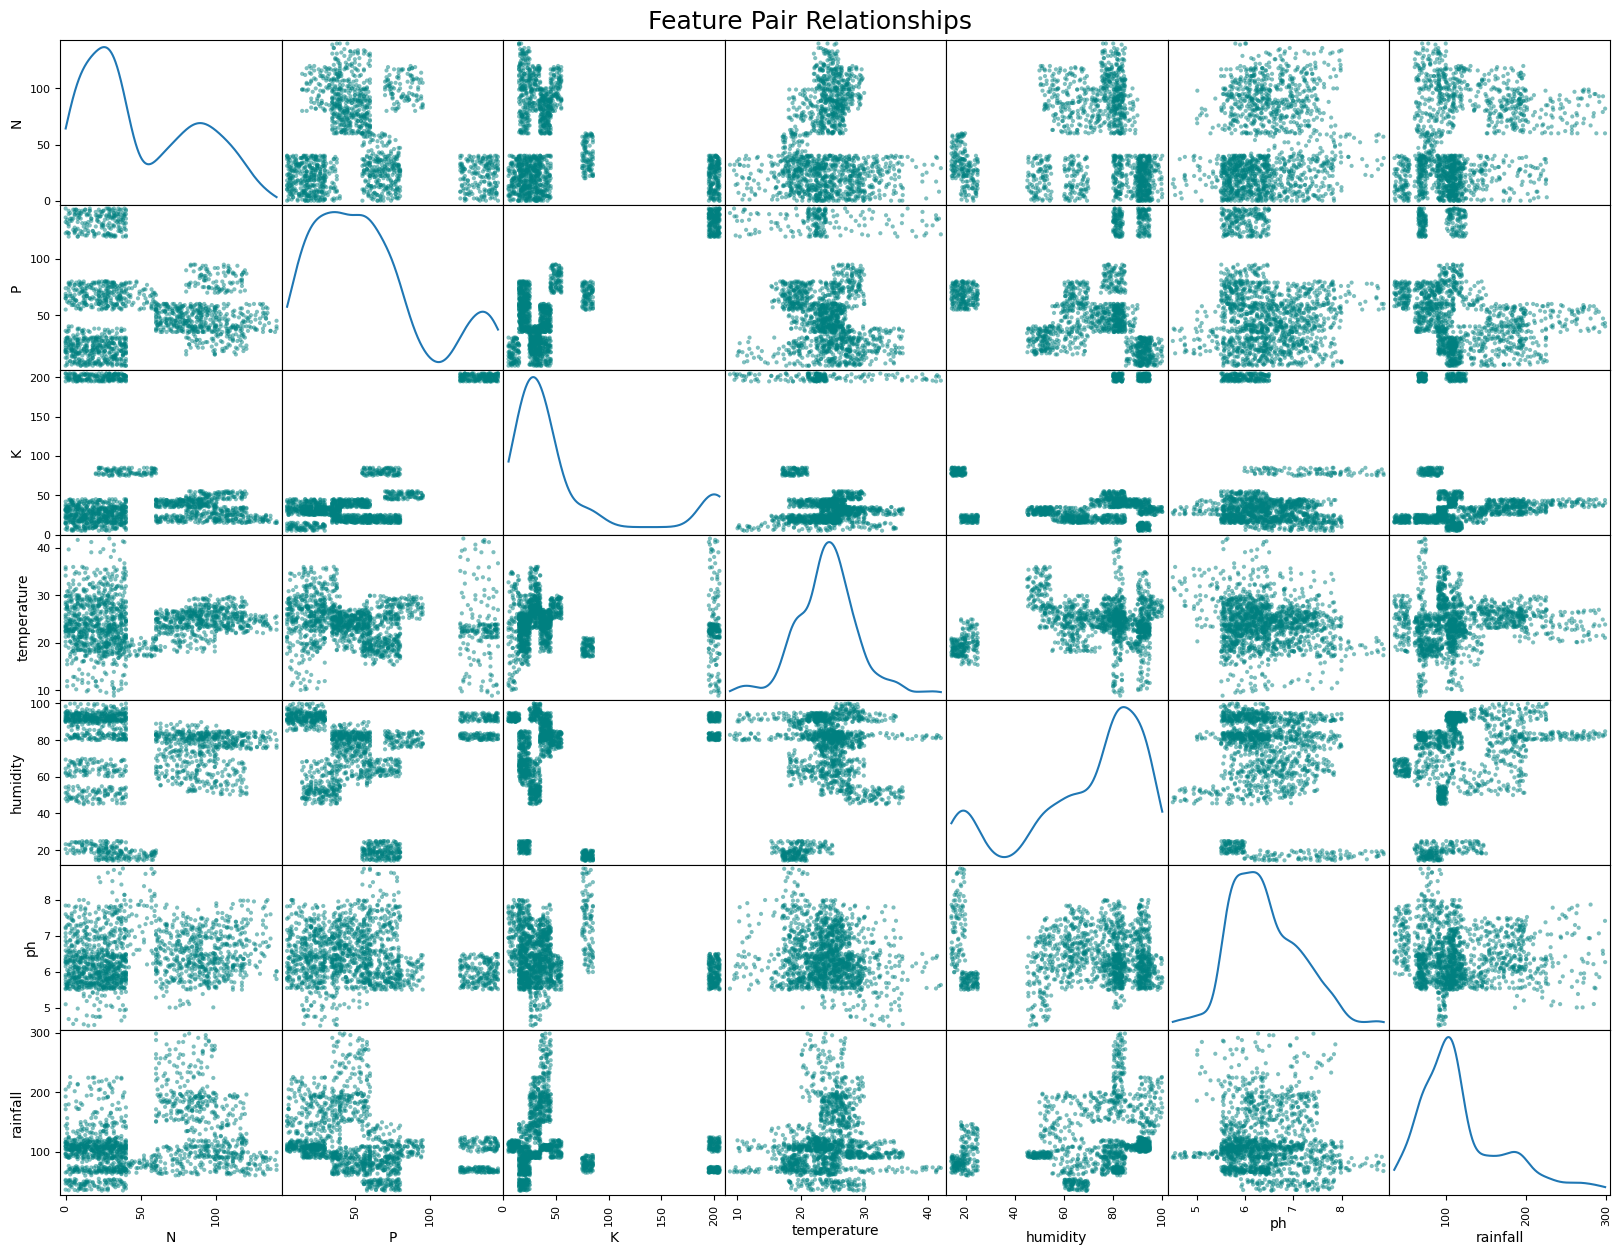

🔍 Insights from Correlation Matrix:

• Strong correlations (|r| > 0.7):
    P & K: 0.84

• Top 3 most correlated pairs:
    P & K: 0.84
    P & rainfall: -0.32
    humidity & rainfall: 0.28

• 3 least correlated pairs:
    N & humidity: 0.06
    ph & rainfall: -0.05
    P & humidity: -0.02

🔍 Descriptive Statistics & Distribution Shape:

• N:
    Mean = 50.62, Median = 37.00, Std = 37.76
    Skewness = 0.49 (approximately symmetric)

• P:
    Mean = 56.65, Median = 51.00, Std = 36.79
    Skewness = 0.93 (moderately skewed)

• K:
    Mean = 55.29, Median = 34.00, Std = 59.11
    Skewness = 1.86 (highly skewed)

• temperature:
    Mean = 24.08, Median = 24.14, Std = 4.69
    Skewness = 0.10 (approximately symmetric)

• humidity:
    Mean = 70.06, Median = 80.00, Std = 23.80
    Skewness = -1.10 (highly skewed)

• ph:
    Mean = 6.42, Median = 6.31, Std = 0.71
    Skewness = 0.52 (moderately skewed)

• rainfall:
    Mean = 116.08, Median = 105.06, Std = 50.94
    Skewness = 1.14 (highly s

In [11]:
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from scipy.stats import skew

# Scatter Matrix
plt.figure(figsize=(20,15))
scatter_matrix(df[['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']], 
               diagonal='kde', 
               alpha=0.5, 
               figsize=(20,15),
               color='teal')
plt.suptitle("Feature Pair Relationships", fontsize=18, y=0.9) 
plt.savefig('5_scatter_matrix.png', dpi=300)
plt.show()
plt.close()
# Define the features you're working with

# Define your features
features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']

# 1. Correlation matrix and strong correlations
corr_matrix = df[features].corr()

print("🔍 Insights from Correlation Matrix:\n")

# Strong correlations (|r| > 0.7)
threshold = 0.7
strong = [(f1, f2, corr_matrix.loc[f1, f2])
          for i, f1 in enumerate(features)
          for f2 in features[i+1:]
          if abs(corr_matrix.loc[f1, f2]) > threshold]

if strong:
    print("• Strong correlations (|r| > 0.7):")
    for f1, f2, r in strong:
        print(f"    {f1} & {f2}: {r:.2f}")
else:
    print("• No correlations above ±0.7 found.")

# 2. Top 3 and bottom 3 feature‐pairs by |correlation|
pairs = [(f1, f2, corr_matrix.loc[f1, f2])
         for i, f1 in enumerate(features)
         for f2 in features[i+1:]]
pairs_sorted = sorted(pairs, key=lambda x: abs(x[2]), reverse=True)

print("\n• Top 3 most correlated pairs:")
for f1, f2, r in pairs_sorted[:3]:
    print(f"    {f1} & {f2}: {r:.2f}")

print("\n• 3 least correlated pairs:")
for f1, f2, r in pairs_sorted[-3:]:
    print(f"    {f1} & {f2}: {r:.2f}")

# 3. Descriptive statistics + distribution shape
print("\n🔍 Descriptive Statistics & Distribution Shape:")
stats = df[features].agg(['mean','median','std']).T

for feat in features:
    m, med, sd = stats.loc[feat]
    sk = skew(df[feat])
    
    shape = ("highly skewed" if abs(sk)>1 else 
             "moderately skewed" if abs(sk)>0.5 else 
             "approximately symmetric")
   
    
    print(f"\n• {feat}:")
    print(f"    Mean = {m:.2f}, Median = {med:.2f}, Std = {sd:.2f}")
    print(f"    Skewness = {sk:.2f} ({shape})")